In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import mesa
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import pickle
from ipywidgets import interact, IntSlider, SelectionSlider, Layout, fixed
import numpy as np
from tqdm import tqdm
slider_layout = Layout(width='300px')




**Changes Summary**:

For details, see below.

- Ideological orientation: is now a continuous scale, with liberal being positive values and conservative negative values. The starting population is drawn from a normal distribution with a mean and sd that we can set.
- Researcher populations: there are now candidate researchers and tenured researchers. When a tenured researcher retires, they are replaced by a candidate researcher. Both publish papers, but only candidates self censure. They retire at different ages.
- Hiring dynamics: Candidates replace retiring tenured researchers on the basis of the mean ideology of tenured resaerchers and number of accepted ideas.

**Model parameters:**


- N: Number of tenured and candidate researchers in the starting pool. The number of tenured is N, the number of candidates is 2*N.
- num_ideas: number of ideas in the starting pool.
- mean_ideology: the mean ideology of initialized researchers and initialized ideological ideas
- sd_ideology: Standard deviation of the distribution from which starting ideologies are sampled. The larger this is, the more variation in these.
- error: proportion of false positives and false negatives in peer review without ideological bias
- p_false_positive: increase in proportion in false positives due to ideological bias
- p_false_negative: increase in proportion in false negatives due to ideological bias
- p_true_start: proportion of true ideas in the starting population of ideas
- p_new_idea: probability in any given step of each researcher to launch a new idea 
- p_new_idea_true: probability that a newly launched idea is true
- p_ideology_idea: probability that a newly launched idea is ideological. If it is not ideological, it has ideology 0 and is neutral.
- promotion_weight_ideology: Candidates are selected for promotion on the basis of their ideology (in line with dominant or not) and number of papers published. This number (a value between 0 and 1) determines the weight of ideology. If set to 0, ideology does not play a role, if set to 1 the number of papers doesn't play a role.
- p_ideology_reviewer: modifies how likely it is that you get a reviewer with the same ideology as the idea
- censure: true or false for whether candidates from the minority ideology refrain from publishing ideological ideas. If True, to only publish neutral ideas.
- sd_ideas: How much the orientation of a newly launched ideological idea can be different from that of its originator.


**The model has the following assumptions about researchers:**

*Two populations & population composition:*
- There is a population of candidate researchers and a population of tenured researchers.
- At initialization, the candidate researchers are between 23 and 35, and the tenured researchers are between 25 and 65.
- Candidate researchers retire at 65, candidate researchers retire at 35.
- The pool of candidate researchers is twice as big as that of tenured researchers.
- When tenured researchers retire, they are replaced by a candidate researcher who then gets promoted. This candiate then gets replaced by a new candidate researcher. Thus, the total number of researchers always remains the same.
- Candidates are promoted for selection on the basis of the number of accepted ideas they launched over the previous 10 ticks of the model and on the basis of their ideology. If their ideology is in line with the mean ideology, they get a boost in their chances to get hired, while if it is not they get a punishment. The parameter 'promotion_weight_ideology' determines the weight of ideology in the promotion decision. If it is set at 0, the decision is made entirely on the basis of number of papers. A higher value (between 0 and 1) gives more weight to ideology. Note: we could change this dynamic, and instead of letting the mean ideology determine the punishment/boost, we could let the ideology of the retiring researcher do that. Maybe this is more realistic?
- Retiring candidates and promoted candidates are replaced by new candidates with an orientation randomly sampled from a normal distribution with mean 0 and sd 'sd_ideology'. In other words, their orientation is independent from the current mean or from the person they are replacing.

*Idealogical Orientation:*
- Each researcher has an ideological orientation which is on a continuous scale around 0 (neutral). Positive numbers are liberal, and negative numbers are conservative. 
- The ideology of the starting population of researchers is sampled from a normal distribution with mean 'mean_ideology' and standard deviation 'sd_ideology'. This is supposed to reflect the 1950s. Note: we could change this distribution on the basis of what we know about the 50ies. Is more of the mass towards the mean, or does it have longer tails? Is the distribution skewed? etc.


*Launching and reviewing ideas:*
- Every six months, each researcher launches a new idea with a probability of p_new_idea (currently 0.8)
- This idea has a probability of being true of p_new_idea_true (currently 0.5)
- This idea is either neutral or ideological, and this proportion is determined by 'p_ideology_idea'. If it is ideological, its orientation is sampled from a normal distribution with the orientation of the researcher set as the mean and the standard deviation 'sd_ideas'. 
- This idea is reviewed by two random other researchers from the population, and only added to the population of ideas if both reviewers think the idea is true.
- If the 'censure' parameter is set to True, candidate_researchers who have an orientation that is not in line with the mean orientation will only launch neutral ideas.

**The model has the following assumptions about ideas:**

- All ideas have an idealogical orientation on the same continuous scale as the researchers.
- The initial ideas are either neutral (ideology 0) or ideological, and the proportion is managed by p_ideology_idea. The ideological ideas are sampled from the same normal distribution as the researchers. While new ideas have a probability of being ideological of p_ideology_idea, the initial population has p_ideology_idea / 4. This is to artificially set up that the share of ideological ideas has increased compared to 70 years ago. Note: unsure whether we should do this.
- All ideas are either true or false. The proportion of true ideas in the initial population is p_true_start.
- Each step, we randomly remove the same number of ideas that is added after review. This way, the population of ideas remains the same.

**The model has the following assumptions about peer review:**

- Each newly launched idea is reviewed by two random researchers, and only admitted to the population if it gets considered True by each reviewer.
- Reviewers have basic false positive and false negative raters set by error.
- If a reviewer reviews a paper with their own ideological orientation (liberal reviewing liberal or conservative reviewing conservative -- no effect for neutral ideas or resaerchers), their false positive and false negative rates change:
    - If the ideology of idea and reviewer is the same, the false positive rate (false papers being considered true) increases by p_false_positive.
    - If the ideology of idea and reviewer is different, the false negative rate (true papers being considered false) increases by p_false_negative
- If an idea is ideological, it has an increased probability of getting reviewer with the same orientation. More precisely, there is a certain probability, expressed by parameter 'p_ideology_reviewer', that instead of choosing random reviewers we randomly select 10% of the population and take the two reviewers with the ideology most in line with that of the idea. Note: This is pretty random, so we should think about how precisely we want to do this.

**Questions:**

- The interactive plots have varying variables for all parameters. Which parameters can we keep fixed? I think there are two criteria:
    - Parameters that we know empirically (e.g. values from the 1950ies)
    - Parameters that we are not really interested in, and that don't really have interesting effects such as interactions with other parameters or an effect on ideology. For example, I imagine that changing 'error' just makes more or less ideas false, but doesn't really change any of the model dynamics.
    
- Given the hiring dynamics we've put in (the mean orientation of the population plays a role in selecting candidates to replace retiring researchers) it is not surprising that whenever we run the model, one orientation just ends up dominating rather quickly. If the starting mean orientation is positive, everyone ends up liberal in the end, and vice versa for conservative (and if it is 0, the direction is random depending on noise but also ends in one extreme). Depending on how high the standard deviation of ideological ideas and hiring is, the mean orientation stabilizes after a while when all researchers in the population have the same orientation. *Does this mean we have to change the model dynamics? More precisely, should we use a different mechanism than rewarding candidates for having the same orientation as the mean of the population (and punishing people for the reverse)? We could, for example, check more rigorously if just the effect of ideological bias in peer review is enough to result in liberal domination.* 
    
- The model has become very complex, and outcomes and dynamics depend on parameters for which we cannot really know the true value, such as p_false_positive (the extent to which ideology leads to false positive judgements) or p_ideology_idea (the proportion of ideas that are ideological). *Has the model become too complex to really do anything with it?* Originally we wanted to compare to how science really evolved, but this would require tuning so many unknown parameters that it is not clear that this is meaningful. The other aim we had was to confirm that the dynamics we had in mind really lead to a dominating ideology and more false ideas, and this does indeed seem to be the case. But again, it depends a bit on choosing parameters, and it is maybe not so surprising given the hiring dynamic we chose (using the mean orientation of the population). 

- One further way of makig the model more complex is by adding an epistemic landscape of ideas, part of which is ideological, and investigating how different dynamics mean that different parts of this landscape do or do not get explored. I imagine the outcome of this would just be that the part of the landscape that is more open to the minority opinion would not get explored, so maybe not so interesting. Worth looking into this?

- The total number of ideas and resaerchers is kept stable: for each resaercher that retires, another one is hired, and for each idea that is accepted, another one disappears. This keeps the size of the model manageable, but it makes it a bit less realistic. Is that a problem?

- Should we sample orientations from another distribution than the normal? There must be empirical data about this, maybe people tend to reside in clusters with some variation within these clusters? A micture of gaussian distributions could work for this (see below).

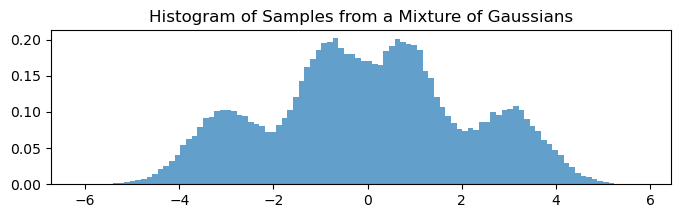

In [486]:
# Parameters for the mixture components
means = [-3,-1,0, 1,3]
variances = [0.6, 0.3, 0.5,0.3,0.6]
weights = [0.2,0.2,0.2,0.2,0.2]  # Equal weights
n_samples = 100000

# Generate samples from each component
samples = np.concatenate([
    np.random.normal(mu, np.sqrt(sigma), int(w*n_samples))
    for mu, sigma, w in zip(means, variances, weights)
])
plt.figure(figsize=(8, 2))  # 10 inches wide by 6 inches tall

# Plotting the samples
plt.hist(samples, bins=100, alpha=0.7, density=True)
plt.title('Histogram of Samples from a Mixture of Gaussians')
plt.show()

# Set up of the model

**Run all the cells in this chapter without trying to understand them.**

In [407]:
from collections import deque


class Researcher(Agent):
    def __init__(self, unique_id, model, orientation, seniority):
        super().__init__(unique_id, model)
        self.orientation = orientation
        self.seniority = seniority

    def step(self):
        if self.seniority >= self.retirement_age:
            self.retire()
        if (random.random() < self.model.p_new_idea) and self.orientation != 'retired':
            self.launch_idea()
        self.seniority += 0.5

    def retire(self):
        self.orientation = "retired"

    def launch_idea(self):
        # could work censure in here:
        # CHECK THIS
        if self.model.censure and self.unique_id in self.model.agents_by_type[Candidate_researcher]:
            if self.orientation * self.model.mean_orientation(Tenured_researcher) > 0:
                orientation = 0 if random.random() > self.model.p_ideology_idea else (np.random.normal(self.orientation, self.model.sd_ideas))
            else:
                orientation = 0
        else:
            orientation = 0 if random.random() > self.model.p_ideology_idea else (np.random.normal(self.orientation, self.model.sd_ideas))
        truth_value = random.choices([True, False], weights=[self.model.p_new_idea_true, 1 - self.model.p_new_idea_true], k=1)[0]
        new_idea = Proposal_idea(self.model.next_id(), self.model, orientation, truth_value, self.unique_id)
        self.model.review_queue.append(new_idea)
        
class Tenured_researcher(Researcher):
    def __init__(self, unique_id, model, orientation, seniority):
        super().__init__(unique_id, model, orientation, seniority)
        self.retirement_age = 65

class Candidate_researcher(Researcher):
    def __init__(self, unique_id, model, orientation):
        starting_seniority = int(random.triangular(23, 35, 27))
        super().__init__(unique_id, model, orientation, starting_seniority)
        self.retirement_age = 36
        self.recent_accepted_ideas = deque(maxlen=10)  # Keeps the count of accepted ideas for the last 10 ticks
        self.accepted_ideas_count = 0  # Total accepted ideas count

    def update_recent_ideas(self, accepted=False):
        if accepted:
            self.recent_accepted_ideas.append(1)
        else:
            self.recent_accepted_ideas.append(0)
        self.accepted_ideas_count += int(accepted)

    def get_recent_ideas_score(self):
        return sum(self.recent_accepted_ideas)
    
# define the ideas

class Idea(Agent):
    def __init__(self, unique_id, model, orientation, truth_value, originator_id):
        super().__init__(unique_id, model)
        self.orientation = orientation
        self.truth_value = truth_value
        self.originator_id = originator_id
        

class Proposal_idea(Idea):
    def __init__(self, unique_id, model, orientation, truth_value, originator_id):
        super().__init__(unique_id, model, orientation, truth_value, originator_id)
        # Any additional properties specific to proposals can be initialized here

class Accepted_idea(Idea):
    def __init__(self, unique_id, model, orientation, truth_value, originator_id):
        super().__init__(unique_id, model, orientation, truth_value, originator_id)
        # Additional properties or methods specific to accepted ideas could be added here





In [408]:
# the model

import logging
logging.basicConfig(level=logging.DEBUG)

class ResearchModel(Model):
    """
    Parameters:
    - N: Number of tenured and candidate researchers in the starting pool.
    - num_ideas: number of ideas in the starting pool.
    - mean_ideology: the mean ideology of initialized researchers and initialized ideological ideas
    - error: proportion of false positives and false negatives in peer review without ideological bias
    - p_false_positive: increase in proportion in false positives due to ideological bias
    - p_false_negative: increase in proportion in false negatives due to ideological bias
    - p_true_start: proportion of true ideas in the starting population of ideas
    - p_new_idea: probability in any given step of each researcher to launch a new idea 
    - p_new_idea_true: probability that a newly launched idea is true
    - p_ideology_idea: probability that a newly launched idea is ideological
    - sd_ideology: how big the difference between the ideology of the researcher and ideological ideas can be
    - promotion_weight_ideology: how strongly should ideology influence promotion (value between 0 and 1)
    - p_ideology_reviewer: modifies how likely it is that you get a reviewer with the same ideology as the idea
    - censure: true or false for whether the minority refrains from publishing ideological ideas
    - sd_ideas: How much the orientation of an ideological idea can be different from that of its originator.
    """

        
    def __init__(self, N, num_ideas, mean_ideology, error, p_false_positive, p_false_negative, 
                p_true_start,p_new_idea,p_new_idea_true,p_ideology_idea, sd_ideology,
                 promotion_weight_ideology, p_ideology_reviewer, censure, sd_ideas):
        
        super().__init__()
        
        self.agents_by_type = defaultdict(list)

   
        
        self.sd_ideology = sd_ideology
        self.mean_ideology = mean_ideology
        self.p_new_idea = p_new_idea
        self.p_new_idea_true = p_new_idea_true
        self.p_ideology_idea = p_ideology_idea
        self.p_true_start = p_true_start
        self.promotion_weight_ideology = promotion_weight_ideology
        self.p_ideology_reviewer = p_ideology_reviewer
        self.error = error
        self.p_false_positive = p_false_positive
        self.p_false_negative = p_false_negative
        self.censure = censure
        self.sd_ideas = sd_ideas
        
        
        
        self.running = True
        self.num_agents = N
        self.current_id = 0
        self.schedule = RandomActivation(self)
        self.year = 0
        
        self.datacollector = DataCollector({
                "Mean Orientation Tenured": lambda m: m.mean_orientation(Tenured_researcher),
                "Mean Orientation Candidate": lambda m: m.mean_orientation(Candidate_researcher),
                "Mean Orientation Accepted Ideas": lambda m: m.mean_orientation_accepted_ideas(),
                "Researchers < -1": lambda m: m.count_orientation_range(Tenured_researcher, -float('inf'), -1),
                "Researchers -1 to 0": lambda m: m.count_orientation_range(Tenured_researcher, -1, 0),
                "Researchers 0 to 1": lambda m: m.count_orientation_range(Tenured_researcher, 0, 1),
                "Researchers > 1": lambda m: m.count_orientation_range(Tenured_researcher, 1, float('inf')),
                "Ideas < -1": lambda m: m.count_orientation_range(Accepted_idea, -float('inf'), -1),
                "Ideas -1 to 0": lambda m: m.count_orientation_range(Accepted_idea, -1, 0),
                "Ideas 0 to 1": lambda m: m.count_orientation_range(Accepted_idea, 0, 1),
                "Ideas > 1": lambda m: m.count_orientation_range(Accepted_idea, 1, float('inf')),
                "True Ideas < -1": lambda m: m.count_truth_orientation_range(True, -float('inf'), -1),
                "True Ideas -1 to 0": lambda m: m.count_truth_orientation_range(True, -1, 0),
                "True Ideas 0 to 1": lambda m: m.count_truth_orientation_range(True, 0, 1),
                "True Ideas > 1": lambda m: m.count_truth_orientation_range(True, 1, float('inf')),
                "False Ideas < -1": lambda m: m.count_truth_orientation_range(False, -float('inf'), -1),
                "False Ideas -1 to 0": lambda m: m.count_truth_orientation_range(False, -1, 0),
                "False Ideas 0 to 1": lambda m: m.count_truth_orientation_range(False, 0, 1),
                "False Ideas > 1": lambda m: m.count_truth_orientation_range(False, 1, float('inf')),
                "Proportion Accepted": lambda m: ((m.accepted_ideas + m.rejected_ideas) / (m.new_ideas * 2)) if m.new_ideas > 0 else 0,
                "True Ideas": lambda m: m.count_truth(True),
                "False Ideas": lambda m: m.count_truth(False),
                "Mean age Tenured": lambda m: m.mean_age(Tenured_researcher),
                 "Mean age Candidate": lambda m: m.mean_age(Candidate_researcher),
            "total candidate Researchers": lambda m: m.count_orientation_range(Candidate_researcher, -float('inf'), 100),
            "total ideas": lambda m: m.count_orientation_range(Accepted_idea, -100, 100),
            "total neutral ideas": lambda m: m.count_neutral_ideas(),
            "total true neutral ideas": lambda m: m.count_true_neutral_ideas()
})
        
        
        self.initialize_researchers(N)

        
        self.review_queue = []  # Queue of ideas waiting for review
        
        self.initialize_ideas(num_ideas)
        
    def add_agent(self, agent):
        """Add an agent to the scheduler and to the type-specific list."""
        self.schedule.add(agent)
        self.agents_by_type[type(agent)].append(agent)

    def remove_agent(self, agent):
        """Remove an agent from the scheduler and the type-specific list."""
        self.agents_by_type[type(agent)].remove(agent)
        self.schedule.remove(agent)
        
        
        
    def step(self):
    # Reset the counters at the start of the step
        self.new_ideas = 0       
        self.accepted_ideas = 0
        self.rejected_ideas = 0
        self.double_accepted_ideas = 0

        # Process retirements and new reviews
        self.check_retirements_and_replace()
        
        # Advance the model by one step
        self.schedule.step()

        self.process_review_queue()

            
        # Remove ideas after all operations that could add new ideas
        self.remove_ideas()

        # Increment the model year or simulation time
        self.year += 1
        self.datacollector.collect(self)


        
    

        

    
    def next_id(self):
        """Generate the next unique ID."""
        unique_id = self.current_id
        self.current_id += 1
        return unique_id

    def initialize_ideas(self, num_ideas):
        for i in range(num_ideas):
            orientation = self.random_orientation()
            truth_value = random.choices([True, False], weights=[self.p_true_start, 1-self.p_true_start], k=1)[0]
            originator_id = -1  # Placeholder value
            idea = Accepted_idea(self.next_id(), self, orientation, truth_value, originator_id)
            # self.schedule.add(idea) HEREHO
            self.add_agent(idea)

    def random_orientation(self):
        
        # a certain proportion of ideas is 0 (not ideological)
        # the rest is ideological with values around the mean ideology being more likely
        # divide p_ideology_idea by four to make sure that academia is more ideological now than it used to be (more ideological ideas)
        orientation = 0 if random.random() > (self.p_ideology_idea/4) else np.random.normal(self.mean_ideology, self.sd_ideology)
        
        return orientation


    
    def initialize_researchers(self, N):
    # Initialize tenured researchers
        for i in range(int(N/2)):
            orientation = np.random.normal(self.mean_ideology, self.sd_ideology)
                                         
            # Assign a random age (seniority) between 25 and 65
            seniority = random.randint(25, 65)
            # Create a new researcher agent
            researcher = Tenured_researcher(self.next_id(), self, orientation, seniority)
            # Add the researcher to the schedule
            self.add_agent(researcher)
            # self.schedule.add(researcher) HEREHO

    # Initialize candidate researchers
        for i in range(int(N)):
            orientation = np.random.normal(self.mean_ideology, self.sd_ideology)
            new_candidate = Candidate_researcher(self.next_id(), self, orientation)
            # self.schedule.add(new_candidate) HEREHO
            self.add_agent(new_candidate)

        
    def promote_candidates(self, num_promotions, orientations):
        
        # Calculate promotion scores for each candidate
        # candidates = [c for c in self.schedule.agents if isinstance(c, Candidate_researcher) and c.orientation != 'retired'] HEREHO
        candidates = [agent for agent in self.agents_by_type[Candidate_researcher] if agent.orientation != "retired"]
        for candidate in candidates:
            papers_score = candidate.get_recent_ideas_score()
            
            # check if they have the same sign, i.e. whether they are in line with the ruling orientation
            if (candidate.orientation * self.mean_orientation(Tenured_researcher)) > 0:
                
                ideology_score = abs(candidate.orientation)
            else:
                ideology_score = -abs(candidate.orientation)
            
            candidate.promotion_score = ((1 - self.promotion_weight_ideology) * papers_score) + self.promotion_weight_ideology * ideology_score

        # Sort candidates by their computed promotion score and promote the number that is needed
        candidates.sort(key=lambda x: x.promotion_score, reverse=True)
        for candidate in candidates[:num_promotions]:
            self.promote_to_tenured(candidate)
            # replace that candidate by a new one
            

    def promote_to_tenured(self, candidate):
        
        # self.schedule.remove(candidate) HEREHO
        self.remove_agent(candidate)
    
        # Create a new tenured researcher and add to schedule
        new_tenured = Tenured_researcher(candidate.unique_id, self, candidate.orientation, candidate.seniority)
        # logging.debug(f"Promoting candidate {new_tenured.unique_id}")
        # self.schedule.add(new_tenured) HEREHO
        self.add_agent(new_tenured)
        # Add a new candidate to maintain population
        self.add_new_candidate()
        
        # logging.debug(f"Added new tenured researcher.")


        
        
    def check_retirements_and_replace(self):
        # retired_candidate = [agent for agent in self.schedule.agents if isinstance(agent, Candidate_researcher) and agent.orientation == "retired"] HEEREHO
        retired_candidate = [agent for agent in self.agents_by_type[Candidate_researcher] if agent.orientation == "retired"]
        # logging.debug(f"candidate ages: {[i.seniority for i in [agent for agent in self.schedule.agents if isinstance(agent, Candidate_researcher)]]}")
        # if len(retired_candidate) > 0:
            # logging.debug(f"candidate people to retire: {len(retired_candidate)}")
            # logging.debug(f"candidate people to retire: {[i.unique_id for i in retired_candidate]}")
        for retired in retired_candidate:
            # Remove the retired tenured researcher
            # self.schedule.remove(retired) HEREHO
            self.remove_agent(retired)
            self.add_new_candidate()
            
        # retired_tenured = [agent for agent in self.schedule.agents if isinstance(agent, Tenured_researcher) and agent.orientation == "retired"] HEREHO
        retired_tenured = [agent for agent in self.agents_by_type[Tenured_researcher] if agent.orientation == "retired"]
        num_retirees = len(retired_tenured)
        
        # if num_retirees > 0:
            # logging.debug(f"tenured people to retire: {num_retirees}")
            # logging.debug(f"tenured people to retire: {[i.unique_id for i in retired_tenured]}")
        orientations = []
        for retired in retired_tenured:
            # Remove the retired tenured researcher
            # logging.debug(f"tenured count before retiring: {self.count_orientation_range(Tenured_researcher, -100, 100)}")
            # self.schedule.remove(retired) HEREHO
            self.remove_agent(retired)
            # logging.debug(f"tenured count after retiring: {self.count_orientation_range(Tenured_researcher, -100, 100)}")
        self.promote_candidates(num_retirees, orientations)
        
        

            
            
    def add_new_candidate(self):
        # let's assume they can have any ideology when they start as a candidate
        orientation = np.random.normal(0, self.sd_ideology)
        # Create and add a new candidate researcher
        new_candidate = Candidate_researcher(self.next_id(), self, orientation)
        # self.schedule.add(new_candidate) HEREHO
        self.add_agent(new_candidate)
        # logging.debug(f"New candidate added: {new_candidate.unique_id}")

    
    def process_review_queue(self):
        for idea in list(self.review_queue):  # Iterate over a copy since we'll modify the queue
            # Exclude the idea's originator from potential reviewers
            self.new_ideas += 1
            if random.random() < self.p_ideology_reviewer:
                # potential_reviewers = [a for a in self.schedule.agents if isinstance(a, Tenured_researcher) and a.unique_id != idea.originator_id and a.orientation != 'retired'] HEREHO
                potential_reviewers = [agent for agent in self.agents_by_type[Tenured_researcher] if agent.unique_id != idea.originator_id and agent.orientation != 'retired']
                reviewers = random.sample(potential_reviewers, int(N*0.05))  # Choose 10% random reviewers
                
                # to let ideology play a role, choose the two reviewers with the strongest ideology that is in the same direction as the idea
                sorted_reviewers = sorted(reviewers, key=lambda agent: agent.orientation, reverse=idea.orientation > 0)
                reviewers = sorted_reviewers[:2]
                
            else:
                #potential_reviewers = [a for a in self.schedule.agents if isinstance(a, Tenured_researcher) and a.unique_id != idea.originator_id and a.orientation != 'retired'] HEREHO
                potential_reviewers = [agent for agent in self.agents_by_type[Tenured_researcher] if agent.unique_id != idea.originator_id and agent.orientation != 'retired']
                reviewers = random.sample(potential_reviewers, 2)  # Choose two random reviewers

            
            # Determine if the idea is accepted based on reviewers' evaluation
            if self.evaluate_idea(idea, reviewers):
                
                accepted_idea = Accepted_idea(idea.unique_id, self, idea.orientation, idea.truth_value, idea.originator_id)
                self.double_accepted_ideas += 1
                #self.schedule.add(accepted_idea)
                self.add_agent(accepted_idea)
                
                
            self.review_queue.remove(idea)  # Remove the idea from the queue regardless of outcome

    def evaluate_idea(self, idea, reviewers):
        verdicts = []
        for reviewer in reviewers:
            # Base probabilities for false positive and false negative
            fp, fn = self.error, self.error  

            # Determine the adjustments to false positive and false negative rates based on orientation
            # When idea orientation is zero, no additional bias is added.
            if idea.orientation != 0:
                # Positive values are liberal, negative values are conservative
                # Same sign implies matching orientations (both liberal or both conservative)
                if (idea.orientation * reviewer.orientation) > 0:
                    fp += self.p_false_positive  # Increase false positive rate if orientations match

                # Opposite signs imply opposing orientations (one liberal, one conservative)
                else:
                    fn += self.p_false_negative  # Increase false negative rate for opposing orientations

            # Determine reviewer's verdict
            if not idea.truth_value and random.random() < fp:
                verdicts.append(True)  # False idea judged as true
                self.accepted_ideas += 1
            elif idea.truth_value and random.random() < fn:
                verdicts.append(False)  # True idea judged as false
                self.rejected_ideas += 1
            else:
                verdicts.append(idea.truth_value)
        

        return all(verdicts)

        
    def remove_ideas(self):
        # Determine 10% of the current idea population
        # all_ideas = [agent for agent in self.schedule.agents if isinstance(agent, Accepted_idea)] HEREHO
        all_ideas = self.agents_by_type[Accepted_idea] 
        num_to_remove = self.double_accepted_ideas
        # Randomly select ideas to remove
            # Randomly select the necessary number of ideas to remove
        if len(all_ideas) >= num_to_remove:
            ideas_to_remove = random.sample(all_ideas, num_to_remove)
            for idea in ideas_to_remove:
                self.remove_agent(idea) #HEREHO
## HEREHO            
#     def mean_orientation(self, agent_type):
#         orientations = [agent.orientation for agent in self.schedule.agents if isinstance(agent, agent_type) and hasattr(agent, 'orientation')and isinstance(agent.orientation, (int, float))]
#         return np.mean(orientations) if orientations else 0
    
#     def mean_age(self, agent_type):
#         seniorities = [agent.seniority for agent in self.schedule.agents if isinstance(agent, agent_type) and hasattr(agent, 'seniority')and isinstance(agent.seniority, (int, float))]
#         return np.mean(seniorities) if seniorities else 0

#     def mean_orientation_accepted_ideas(self):
#         orientations = [idea.orientation for idea in self.schedule.agents if isinstance(idea, Accepted_idea) and isinstance(idea.orientation, (int, float))]
#         return np.mean(orientations) if orientations else 0

#     def count_orientation_range(self,agent_type, min_val, max_val):
#         return sum(1 for agent in self.schedule.agents if isinstance(agent, agent_type) and isinstance(agent.orientation, (int, float)) and min_val < agent.orientation < max_val )

#     def count_truth_orientation_range(self, truth_value, min_val, max_val):
#         return sum(1 for idea in self.schedule.agents if isinstance(idea, Accepted_idea) and isinstance(idea.orientation, (int, float)) and idea.truth_value == truth_value and min_val < idea.orientation < max_val )

#     def count_neutral_ideas(self):
#         return sum(1 for idea in self.schedule.agents if isinstance(idea, Accepted_idea) and idea.orientation == 0)
    
#     def count_true_neutral_ideas(self):
#         return sum(1 for idea in self.schedule.agents if isinstance(idea, Accepted_idea) and idea.orientation == 0 and idea.truth_value == True)
    
   
   
#     def count_truth(self, truth_value):
#         """Count ideas with a given truth value."""
#         count = 0
#         for agent in self.schedule.agents:
#             if isinstance(agent, Accepted_idea) and agent.truth_value == truth_value:
#                 count += 1
#         return count

    def mean_orientation(self, agent_type):
        if agent_type in self.agents_by_type:
            orientations = [agent.orientation for agent in self.agents_by_type[agent_type] if isinstance(agent.orientation, (int, float))]
            return np.mean(orientations) if orientations else 0
        return 0
    
    def mean_age(self, agent_type):
        if agent_type in self.agents_by_type:
            seniorities = [agent.seniority for agent in self.agents_by_type[agent_type] if isinstance(agent.seniority, (int, float))]
            return np.mean(seniorities) if seniorities else 0
        return 0
    
    def mean_orientation_accepted_ideas(self):
        if Accepted_idea in self.agents_by_type:
            orientations = [idea.orientation for idea in self.agents_by_type[Accepted_idea]]
            return np.mean(orientations) if orientations else 0
        return 0
    
    def count_orientation_range(self, agent_type, min_val, max_val):
        if agent_type in self.agents_by_type:
            return sum(1 for agent in self.agents_by_type[agent_type] if agent.orientation != 'retired' and min_val < agent.orientation < max_val)
        return 0
    
    def count_truth_orientation_range(self, truth_value, min_val, max_val):
        
        return sum(1 for idea in self.agents_by_type[Accepted_idea] if idea.truth_value == truth_value and min_val < idea.orientation < max_val)

    
    def count_neutral_ideas(self):
        
        return sum(1 for idea in self.agents_by_type[Accepted_idea] if idea.orientation == 0)

    
    def count_true_neutral_ideas(self):
        
        return sum(1 for idea in self.agents_by_type[Accepted_idea] if idea.orientation == 0 and idea.truth_value == True)


    def count_truth(self, truth_value):
        """Count ideas with a given truth value using the agents_by_type dictionary."""
        
        return sum(1 for idea in self.agents_by_type[Accepted_idea] if idea.truth_value == truth_value)



# Plotting

# Run one instance of the model

Run the cell below, but first choose values for the various parameters. They are explained at the start of this notebook, and there is some explanation for each of them here as well. To change the values, just delete the value in brigh/light green, and replace by another. Run the cell after doing that. Note: the higher n_ticks, N and num_ideas, the longer it will take to run the model.

### Profile

In [213]:
# import cProfile
# import pstats
# import io

# def profile_model_run():
#     # Assuming you have a function to create and run your model called `run_model`
#     def run_model():
#         model = ResearchModel(N, num_ideas, mean_ideology, error, p_false_positive, p_false_negative, 
#                 p_true_start,p_new_idea,p_new_idea_true,p_ideology_idea, sd_ideology,
#                  promotion_weight_ideology, p_ideology_reviewer)
#         for _ in tqdm(range(n_ticks)):  # Let's say n_ticks is the number of ticks you want to run
#             model.step()

#     # Create a Profile object and run the run_model function under its context
#     pr = cProfile.Profile()
#     pr.enable()
#     run_model()
#     pr.disable()

#     # Create a stream for the report and print the stats
#     s = io.StringIO()
#     sortby = 'time'  # You can sort by 'time', 'calls', etc.
#     ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
#     ps.print_stats()
#     print(s.getvalue())

# # Call the profiling function
# profile_model_run()

### Run

In [409]:
logging.basicConfig(level=logging.DEBUG)
"""
Parameters:
- N: Number of tenured and candidate researchers in the starting pool.
- num_ideas: number of ideas in the starting pool.
- mean_ideology: the mean ideology of initialized researchers and initialized ideological ideas
- error: proportion of false positives and false negatives in peer review without ideological bias
- p_false_positive: increase in proportion in false positives due to ideological bias
- p_false_negative: increase in proportion in false negatives due to ideological bias
- p_true_start: proportion of true ideas in the starting population of ideas
- p_new_idea: probability in any given step of each researcher to launch a new idea 
- p_new_idea_true: probability that a newly launched idea is true
- p_ideology_idea: probability that a newly launched idea is ideological
- sd_ideology: how big the difference between the ideology of the researcher and ideological ideas can be
- promotion_weight_ideology: how strongly should ideology influence promotion (value between 0 and 1)
- p_ideology_reviewer: modifies how likely it is that you get a reviewer with the same ideology as the idea
- censure: true or false for whether the minority refrains from publishing ideological ideas
- sd_ideas: How much the orientation of an ideological idea can be different from that of its originator.
"""

# run the model and visualize what's happening
from collections import defaultdict

results = []
N =1000 #Number of researchers in the population (constant).
num_ideas =1000# number of ideas in the starting pool.
mean_ideology = 0 #the mean ideology of initialized researchers and initialized ideological ideas
error = 0.1 #proportion of false positives and false negatives in peer review without ideological bias
p_false_positive = 0.6 #increase in proportion in false positives due to ideological bias
p_false_negative = 0.6 #increase in proportion in false negatives due to ideological bias
p_true_start = 0.9 # proportion of true ideas in the starting population of ideas
p_new_idea = 0.5  # probability in any given step of each researcher to launch a new idea
p_new_idea_true = 0.5 #probability that a newly launched idea is true
p_ideology_idea = 0.6 #probability that a newly launched idea is ideological
sd_ideology=1 # how big the variation in ideology can be
promotion_weight_ideology = 0.7 #how strongly should ideology influences promotion (value between 0 and 1)
p_ideology_reviewer = 0.7 # modifies how likely it is that you get a reviewer with the same ideology as the idea
n_ticks = 300 # number of half years the model should run
censure =True
sd_ideas = 0.3




model = ResearchModel(N, num_ideas, mean_ideology, error, p_false_positive, p_false_negative, 
                p_true_start,p_new_idea,p_new_idea_true,p_ideology_idea, sd_ideology,
                 promotion_weight_ideology, p_ideology_reviewer,censure, sd_ideas)

for _ in tqdm(range(n_ticks)):

    model.step() 
logging.basicConfig(level=logging.CRITICAL)

model_data = model.datacollector.get_model_vars_dataframe()


100%|██████████| 300/300 [01:00<00:00,  4.97it/s]


In [410]:

# Set it to None to display all columns/rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

model_data['true_ideas'] = model_data[[ 'True Ideas < -1', 'True Ideas -1 to 0', 'True Ideas 0 to 1',
       'True Ideas > 1', 'False Ideas < -1']].sum(axis = 1)
model_data['false_ideas'] = model_data[['False Ideas -1 to 0',
       'False Ideas 0 to 1', 'False Ideas > 1']].sum(axis = 1)


model_data['con'] = model_data['True Ideas -1 to 0'] +  model_data['False Ideas -1 to 0']
model_data['e_con'] = model_data['True Ideas < -1'] +  model_data['False Ideas < -1']
model_data['lib'] = model_data['True Ideas 0 to 1'] +  model_data['False Ideas 0 to 1']
model_data['e_lib'] = model_data['True Ideas > 1'] +  model_data['False Ideas > 1']
model_data['total_researchers'] = model_data.iloc[:,3:7].sum(axis = 1)


model_data.tail(3)


,Mean Orientation Tenured,Mean Orientation Candidate,Mean Orientation Accepted Ideas,Researchers < -1,Researchers -1 to 0,Researchers 0 to 1,Researchers > 1,Ideas < -1,Ideas -1 to 0,Ideas 0 to 1,Ideas > 1,True Ideas < -1,True Ideas -1 to 0,True Ideas 0 to 1,True Ideas > 1,False Ideas < -1,False Ideas -1 to 0,False Ideas 0 to 1,False Ideas > 1,Proportion Accepted,True Ideas,False Ideas,Mean age Tenured,Mean age Candidate,total candidate Researchers,total ideas,total neutral ideas,total true neutral ideas,true_ideas,false_ideas,con,e_con,lib,e_lib,total_researchers
297,1.750875,-0.154227,0.659875,0,0,0,490,9,17,255,329,8,16,162,207,1,1,93,122,0.301105,778,222,47.470,32.1970,944,1000,390,385,394,216,17,9,255,329,490
298,1.752368,-0.154433,0.670339,0,0,0,493,8,16,250,335,8,15,165,214,0,1,85,121,0.261972,789,211,47.227,32.2355,929,1000,391,387,402,207,16,8,250,335,493
299,1.758440,-0.151101,0.676705,0,0,0,489,8,11,255,336,8,11,167,196,0,0,88,140,0.282178,770,230,47.223,32.1425,950,1000,390,388,382,228,11,8,255,336,489


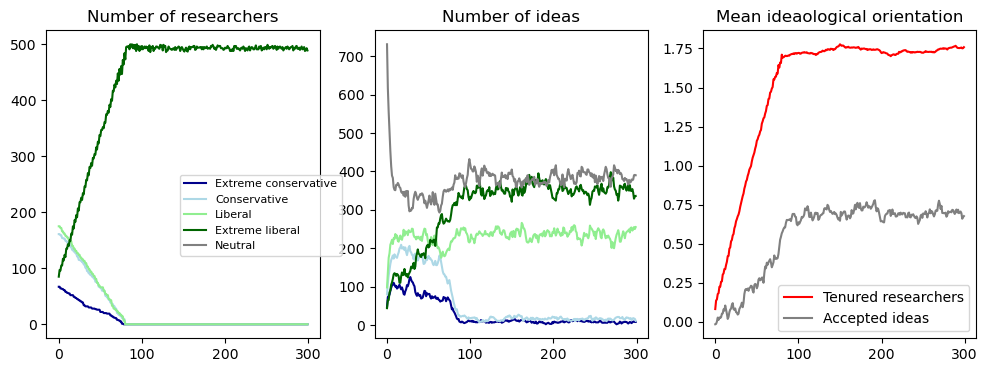

In [411]:
fig, ax = plt.subplots(ncols = 3, figsize = (12,4))


ax[0].plot(range((n_ticks)),model_data.iloc[:,3], color = 'darkblue')
ax[0].plot(range((n_ticks)),model_data.iloc[:,4], color = 'lightblue')
ax[0].plot(range((n_ticks)),model_data.iloc[:,5], color = 'lightgreen')
ax[0].plot(range((n_ticks)),model_data.iloc[:,6], color = 'darkgreen')


ax[0].set_title('Number of researchers')

ax[1].plot(range((n_ticks)),model_data['e_con'], color = 'darkblue')
ax[1].plot(range((n_ticks)),model_data['con'], color = 'lightblue')
ax[1].plot(range((n_ticks)),model_data['lib'], color = 'lightgreen')
ax[1].plot(range((n_ticks)),model_data['e_lib'], color = 'darkgreen')
ax[1].plot(range((n_ticks)),model_data['total neutral ideas'], color = 'grey')

ax[1].legend(['Extreme conservative','Conservative','Liberal','Extreme liberal','Neutral'],loc='center right', 
             frameon=True, fontsize = 8,bbox_to_anchor=(-0.1, 0.4))
ax[1].set_title('Number of ideas')



ax[2].plot(range((n_ticks)),model_data.iloc[:,0], color = 'r')
ax[2].plot(range((n_ticks)),model_data.iloc[:,2], color = 'grey')

ax[2].legend(['Tenured researchers','Accepted ideas'])
ax[2].set_title('Mean ideaological orientation')


plt.show()

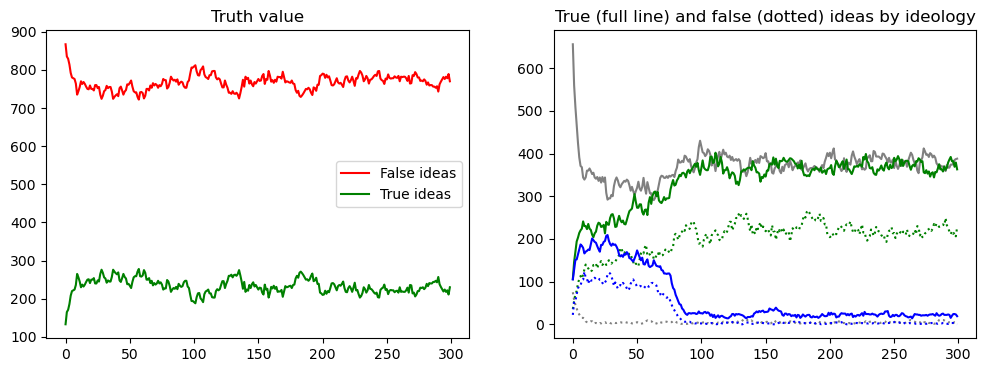

In [412]:
fig, ax = plt.subplots(ncols =2, figsize = (12,4))


ax[0].plot(range((n_ticks)),model_data['True Ideas'], color = 'red')
ax[0].plot(range((n_ticks)),model_data['False Ideas'], color = 'green')

ax[0].legend(['False ideas','True ideas'])
ax[0].set_title('Truth value')

ax[1].plot(range((n_ticks)),model_data['total neutral ideas'] - model_data['total true neutral ideas'], color = 'grey', linestyle = ':')
ax[1].plot(range((n_ticks)),model_data['total true neutral ideas'], color = 'grey')
ax[1].plot(range((n_ticks)),model_data['True Ideas > 1'] + model_data['True Ideas 0 to 1'], color = 'green')
ax[1].plot(range((n_ticks)),model_data['False Ideas > 1'] + model_data['False Ideas 0 to 1'], color = 'green', linestyle = ':')
ax[1].plot(range((n_ticks)),model_data['True Ideas < -1'] + model_data['True Ideas -1 to 0'], color = 'blue')
ax[1].plot(range((n_ticks)),model_data['False Ideas < -1'] + model_data['False Ideas -1 to 0'], color = 'blue', linestyle = ':')


# ax[1].plot(range((n_ticks)),model_data.iloc[:,4]/ model_data['total_researchers'], color = 'lightblue')
# ax[1].plot(range((n_ticks)),model_data.iloc[:,5]/ model_data['total_researchers'], color = 'lightgreen')
# ax[1].plot(range((n_ticks)),model_data.iloc[:,6]/ model_data['total_researchers'], color = 'darkgreen')


ax[1].set_title('True (full line) and false (dotted) ideas by ideology')
plt.show()

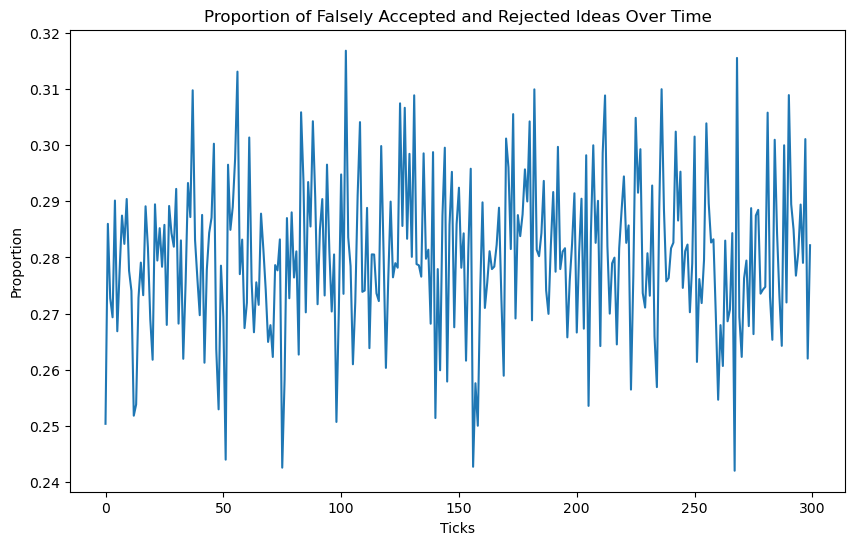

In [413]:
# should be stable as the number of ideological ideas increases

plt.figure(figsize=(10, 6))
plt.plot(model_data["Proportion Accepted"], label="Proportion of Accepted Ideas")

plt.xlabel("Ticks")
plt.ylabel("Proportion")
plt.title("Proportion of Falsely Accepted and Rejected Ideas Over Time")

plt.show()

Ignore the cell below.

In [49]:
# run several iterations to control for unlikely outcomes.

for j in tqdm(range(10)):
    model = ResearchModel(N, num_ideas, mean_ideology, error, p_false_positive, p_false_negative, 
                p_true_start,p_new_idea,p_new_idea_true,p_ideology_idea, sd_ideology,
                 promotion_weight_ideology, p_ideology_reviewer,censure, sd_ideas)
    for _ in range(n_ticks):  # Run for 200 ticks, i.e. 100 years
        model.step()
        
    model_data = model.datacollector.get_model_vars_dataframe()
    results.append(model_data)
    
# get the mean values
array_stack = np.array([df.to_numpy() for df in results])
mean_array = np.mean(array_stack, axis=0)
model_data = pd.DataFrame(mean_array, columns=results[0].columns, index=results[0].index)

# Batch run to compare variables




In [421]:
# Step 1: Define parameters to vary

n_vals = 2

N = 700
num_ideas = 700
n_ticks = 120# number of half years the model should run




variable_params = {'N' : N, 
                   'num_ideas' : num_ideas ,
                   'mean_ideology' : [0.05,0.5] ,
                   'error' : [0.1,0.3] ,
                   'p_false_positive' : np.linspace(0.05, 0.8, n_vals) ,
                   'p_false_negative' : np.linspace(0.05, 0.8, n_vals) ,
                   'p_true_start' : 0.9, 
                   'p_new_idea' : [0.3,0.7],
                   'p_new_idea_true' : [0.3,0.7],
                   'p_ideology_idea' : np.linspace(0.1, 0.8, n_vals),
                   'sd_ideology': [0.2,1],
                   'promotion_weight_ideology' : [0.3,0.7],
                   'p_ideology_reviewer' : np.linspace(0.1,0.8, n_vals),
                  'censure': [True,False],
                  'sd_ideas' : [0.2,1] 
}


# Step 2: Set up BatchRunnerMP
batch_run = mesa.batch_run(
    model_cls=ResearchModel,
    parameters=variable_params,
    data_collection_period = 1,
    # Number of iterations per combination of parameters
    max_steps=n_ticks, 
    number_processes = 1
)


100%|██████████| 4096/4096 [9:35:58<00:00,  8.44s/it]  


In [480]:
df = pd.DataFrame(batch_run)
remove= ['RunId', 'iteration', 'N', 'num_ideas',  'Mean Orientation Candidate','Ideas < -1', 'Ideas -1 to 0', 
         'Ideas 0 to 1', 'Ideas > 1',  'Mean age Tenured', 'Mean age Candidate','total candidate Researchers', 
         'total ideas']
list_cols = [i for i in df.columns if i not in remove]
df = df[list_cols]

In [481]:

with open('version2_test3.pkl', 'wb') as file:
    pickle.dump(df, file)


In [487]:
# The file is too big for github
# split into chunks of 25mb

import os

def split_file(file_path, part_size=25*1024*1024):
    """Split a file into parts, ensuring each part is fully written."""
    file_size = os.path.getsize(file_path)
    num_parts = file_size // part_size + (file_size % part_size > 0)
    parts = []
    with open(file_path, 'rb') as file:
        for i in range(num_parts):
            part_file_name = f'part_{i}.pkl'
            with open(part_file_name, 'wb') as part_file:
                data = file.read(part_size)
                part_file.write(data)
            actual_size = os.path.getsize(part_file_name)
            if actual_size != len(data):
                print(f"Error writing part {i}: expected {len(data)}, wrote {actual_size}")
            parts.append(part_file_name)
            print(f'Part {i} created: {part_file_name}')
    return parts
            
split_file('version2_test3.pkl')


Part 0 created: part_0.pkl
Part 1 created: part_1.pkl
Part 2 created: part_2.pkl
Part 3 created: part_3.pkl
Part 4 created: part_4.pkl


['part_0.pkl', 'part_1.pkl', 'part_2.pkl', 'part_3.pkl', 'part_4.pkl']

In [488]:


# Plotting functions

def preprocess_data(filtered_df):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = filtered_df.copy()

    df['true_ideas'] = df[['True Ideas < -1', 'True Ideas -1 to 0', 'True Ideas 0 to 1', 'True Ideas > 1']].sum(axis=1)
    df['false_ideas'] = df[['False Ideas < -1', 'False Ideas -1 to 0', 'False Ideas 0 to 1', 'False Ideas > 1']].sum(axis=1)
    df['con'] = df['True Ideas -1 to 0'] + df['False Ideas -1 to 0']
    df['e_con'] = df['True Ideas < -1'] + df['False Ideas < -1']
    df['lib'] = df['True Ideas 0 to 1'] + df['False Ideas 0 to 1']
    df['e_lib'] = df['True Ideas > 1'] + df['False Ideas > 1']

    return df


def update_plots(p_false_positive, p_false_negative, p_ideology_idea, promotion_weight_ideology, p_ideology_reviewer,
                 censure, mean_ideology,error,p_new_idea,p_new_idea_true, sd_ideology,sd_ideas): #
    filtered_df = df[
        (df['p_false_positive'] == p_false_positive) &
        (df['p_false_negative'] == p_false_negative) &
        (df['p_ideology_idea'] == p_ideology_idea) &
        (df['promotion_weight_ideology'] == promotion_weight_ideology) &
        (df['p_ideology_reviewer'] == p_ideology_reviewer)  &
        (df['censure'] == censure) &
        (df['mean_ideology'] == mean_ideology) &
        (df['error'] == error) &
        (df['p_new_idea'] == p_new_idea) &
        (df['p_new_idea_true'] == p_new_idea_true) &
        (df['sd_ideology'] == sd_ideology) &
        (df['sd_ideas'] == sd_ideas)
        
    ] #

    if filtered_df.empty:
        print("No data available for this combination of parameters.")
        return

    filtered_df = preprocess_data(filtered_df)
    n_ticks = len(filtered_df)  # Assuming the number of ticks is the length of the dataframe

    # Plotting as per your code with slight modifications for clarity and correctness
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten()

    
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers < -1'], color = 'darkblue')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers -1 to 0'], color = 'lightblue')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers 0 to 1'], color = 'lightgreen')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers > 1'], color = 'darkgreen')
    axs[0].set_title('Number of researchers', fontsize = 15)
    

    
    # Number of ideas over time
    axs[1].plot(filtered_df['Step'], filtered_df['e_con'], label='Extreme conservative', color='darkblue')
    axs[1].plot(filtered_df['Step'], filtered_df['con'], label='Conservative', color='lightblue')
    axs[1].plot(filtered_df['Step'], filtered_df['lib'], label='Liberal', color='lightgreen')
    axs[1].plot(filtered_df['Step'], filtered_df['e_lib'], label='Extreme liberal', color='darkgreen')
    axs[1].plot(filtered_df['Step'], filtered_df['total neutral ideas'], label='Neutral', color='grey')
    axs[1].set_title('Number of Ideas', fontsize = 15)
    axs[1].legend()

    # Ideological orientation over time
    axs[2].plot(filtered_df['Step'], filtered_df['Mean Orientation Tenured'], label='Tenured Researchers', color='red')
    axs[2].plot(filtered_df['Step'], filtered_df['Mean Orientation Accepted Ideas'], label='Accepted Ideas', color='grey')
    axs[2].set_title('Mean Ideological Orientation', fontsize = 15)
    axs[2].legend()

    # Truth value of ideas
    axs[3].plot(filtered_df['Step'], filtered_df['False Ideas'], label='False Ideas', color='red')
    axs[3].plot(filtered_df['Step'], filtered_df['True Ideas'], label='True Ideas', color='green')
    axs[3].set_title('Truth Value', fontsize = 15)
    axs[3].legend()

    # True and False Ideas by Ideology
    axs[4].plot(filtered_df['Step'], filtered_df['True Ideas > 1'] + filtered_df['True Ideas 0 to 1'], label='True Liberal', color='green')
    axs[4].plot(filtered_df['Step'], filtered_df['False Ideas > 1'] + filtered_df['False Ideas 0 to 1'], label='False Liberal', color='green', linestyle=':')
    axs[4].plot(filtered_df['Step'], filtered_df['True Ideas < -1'] + filtered_df['True Ideas -1 to 0'], label='True Conservative', color='blue')
    axs[4].plot(filtered_df['Step'], filtered_df['False Ideas < -1'] + filtered_df['False Ideas -1 to 0'], label='False Conservative', color='blue', linestyle=':')
    axs[4].plot(filtered_df['Step'],filtered_df['total neutral ideas'] - filtered_df['total true neutral ideas'], label = 'False neutral ideas', color = 'grey', linestyle = ':')
    axs[4].plot(filtered_df['Step'],filtered_df['total true neutral ideas'], label = 'True neutral ideas', color = 'grey')
    axs[4].set_title('True and False Ideas by Ideology', fontsize = 15)
    axs[4].legend()
    



    # Proportion of Accepted Ideas
    axs[5].plot(filtered_df['Step'], filtered_df['Proportion Accepted'], label='Proportion of ideas', color='purple')
    axs[5].set_title('Proportion of Falsely Accepted and Rejected Ideas Over Time', fontsize = 15)
    axs[5].legend()

    plt.tight_layout()
    plt.show()

    





In [490]:
logging.basicConfig(level=logging.CRITICAL)

style = {'description_width': 'initial'}
slider_layout = widgets.Layout(width='350px')  # Adjust width as needed    
p_false_positive_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.05, 0.8, n_vals)], value=0.05, description='p_false_positive',style=style, layout = slider_layout)
p_false_negative_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.05, 0.8, n_vals)], value=0.05, description='p_false_negative',style=style, layout = slider_layout)
p_ideology_idea_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.1, 0.8, n_vals)], value=0.1, description='p_ideology_idea',style=style, layout = slider_layout)
promotion_weight_ideology_slider = widgets.SelectionSlider(options=[(f"{x:.1f}", x) for x in [0.3, 0.7]], value=0.3, description='Promotion Weight Ideology',style=style, layout = slider_layout)
p_ideology_reviewer_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.1, 0.8, n_vals)], value=0.1, description='p_ideology_reviewer',style=style, layout = slider_layout)
censure_toggle = widgets.ToggleButtons(options=[(str(x), x) for x in [True, False]], value=True, description='Censure')

mean_ideology_slider = widgets.SelectionSlider(options= [0.05,0.5] , value=0.05, description='mean_ideology',style=style, layout = slider_layout)
error_slider = widgets.SelectionSlider(options=[0.1,0.3] , value=0.1, description='error',style=style, layout = slider_layout)
p_new_idea_slider = widgets.SelectionSlider(options=[0.3,0.7], value=0.3, description='p_new_idea',style=style, layout = slider_layout)
p_new_idea_true_slider = widgets.SelectionSlider(options=[0.3,0.7], value=0.3, description='p_new_idea_true',style=style, layout = slider_layout)
sd_ideology_slider = widgets.SelectionSlider(options=[0.2,1], value=0.2, description='sd_ideology',style=style, layout = slider_layout)
sd_ideas_slider = widgets.SelectionSlider(options=[0.2,1], value=0.2, description='sd_ideas',style=style, layout = slider_layout)




ui = widgets.VBox([p_false_positive_slider, p_false_negative_slider, p_ideology_idea_slider, promotion_weight_ideology_slider, p_ideology_reviewer_slider,
                  mean_ideology_slider, error_slider, p_new_idea_slider, p_new_idea_true_slider, sd_ideology_slider ,sd_ideas_slider, censure_toggle]) #
out = widgets.interactive_output(update_plots, {'p_false_positive': p_false_positive_slider, 'p_false_negative': p_false_negative_slider, 'p_ideology_idea': p_ideology_idea_slider, 
                                                'promotion_weight_ideology': promotion_weight_ideology_slider,'p_ideology_reviewer': p_ideology_reviewer_slider, 
                                                 'mean_ideology':mean_ideology_slider, 'error':error_slider,
                                               'p_new_idea':p_new_idea_slider, 'p_new_idea_true':p_new_idea_true_slider, 'sd_ideology':sd_ideology_slider,
                                               'sd_ideas':sd_ideas_slider,'censure': censure_toggle}) #

display(ui, out)



Output()